## Load Model

In [ ]:
import net as net
import tensorflow as tf
num_in_ch = 4
num_out_ch = 3
up_ratio = 4
raw_tol = 4

upsample_type = 'deconv'
with tf.variable_scope(tf.get_variable_scope()):
    input_raw=tf.placeholder(tf.float32,shape=[1,None,None,num_in_ch], name="input_raw")
    out_rgb = net.SRResnet(input_raw, num_out_ch, up_ratio=up_ratio, reuse=False, up_type=upsample_type)

    if raw_tol != 0:
        out_rgb = out_rgb[:,int(raw_tol/2)*(up_ratio*4):-int(raw_tol/2)*(up_ratio*4),
            int(raw_tol/2)*(up_ratio*4):-int(raw_tol/2)*(up_ratio*4),:]  # add a small offset to deal with boudary case

    objDict = {}
    objDict['out_rgb'] = out_rgb

In [ ]:
import tensorflow as tf
restore_path = './model'
gpu_options = tf.GPUOptions(allow_growth=True)
sess=tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
saver_restore=tf.train.Saver([var for var in tf.trainable_variables()])
ckpt=tf.train.get_checkpoint_state("%s"%(restore_path))
print("Contain checkpoint: ", ckpt)
if not ckpt:
    print("No checkpoint found.")
    exit()
else:
    saver_restore.restore(sess,ckpt.model_checkpoint_path)
    
    
print(sess)

## Data Alignment

In [ ]:
import utils
import numpy as np
from PIL import Image
fracx = fracy = 1./2
crop_ratio = 240.0 / 35.0
#crop_ratio = 157.0 / 35.0
inference_path = "/store/git/zoom-learn-zoom/quick_inference/00134/00006.JPG"
rgb_camera =  np.array(Image.open(inference_path))
cropped_input_rgb_lr = utils.crop_fov(rgb_camera, 1./crop_ratio)
cropped_input_rgb_lr = utils.image_float(cropped_input_rgb_lr)
input_camera_rgb_lr = Image.fromarray(np.uint8(utils.clipped(cropped_input_rgb_lr)*255))
input_camera_rgb_naive = input_camera_rgb_lr.resize((int(input_camera_rgb_lr.width * crop_ratio),
        int(input_camera_rgb_lr.height * crop_ratio)), Image.ANTIALIAS)
input_camera_rgb_naive.save("align_test/input_rgb_camera_LR.png")

lr = np.array(input_camera_rgb_naive)

In [ ]:
import utils
import numpy as np
from PIL import Image
fracx = fracy = 1./2
crop_ratio = 240.0 / 157.0 
#crop_ratio = 157.0 / 157.0 

inference_path = "/store/git/zoom-learn-zoom/quick_inference/00134/00002.JPG"
rgb_camera =  np.array(Image.open(inference_path))
cropped_input_rgb_lr = utils.crop_fov(rgb_camera, 1./crop_ratio)
cropped_input_rgb_lr = utils.image_float(cropped_input_rgb_lr)
input_camera_rgb_lr = Image.fromarray(np.uint8(utils.clipped(cropped_input_rgb_lr)*255))
input_camera_rgb_naive = input_camera_rgb_lr.resize((int(input_camera_rgb_lr.width * crop_ratio),
        int(input_camera_rgb_lr.height * crop_ratio)), Image.ANTIALIAS)
input_camera_rgb_naive.save("align_test/input_rgb_camera_LHR.png")

lhr = np.array(input_camera_rgb_naive)

In [ ]:
HR_inference_path = "/store/git/zoom-learn-zoom/quick_inference/00134/00001.JPG"
HR_zoom_ratio = utils.readFocal_pil(HR_inference_path) / utils.readFocal_pil(inference_path)
HR_crop_ratio = crop_ratio / HR_zoom_ratio

HR_camera =  np.array(Image.open(HR_inference_path))
cropped_input_rgb = utils.crop_fov(HR_camera, 1./HR_crop_ratio)
cropped_input_rgb_hr = utils.image_float(cropped_input_rgb)
input_camera_rgb = Image.fromarray(np.uint8(utils.clipped(cropped_input_rgb_hr)*255))
input_camera_rgb.save("align_test/input_rgb_camera_HR.png")

hr = np.array(input_camera_rgb)

In [ ]:
import utils
import cv2
import utils_align
def imgAlign(images, tform_txt, sour_idx, des_idx, clipped=False, height = 2500, width = 2500):
    t1, corner1 = utils.read_tform(tform_txt, "0000"+str(sour_idx))
    t2, corner2 = utils.read_tform(tform_txt, "0000"+str(des_idx))
    t2_inv = cv2.invertAffineTransform(t2)
    aligned_image_np = utils_align.apply_transform_single_image(images, t1, 'ECC', scale=1)
    aligned_image_np = utils_align.apply_transform_single_image(aligned_image_np, t2_inv, 'ECC', scale=1)
    ori_images_np = images
    if clipped == True:
        h, w = aligned_image_np.shape[:2]
        top = int((h - height) / 2)
        left =int((w - width) / 2)
        aligned_image_np = aligned_image_np[top:top+height,left:left+width,:]
        ori_images_np = images[top:top+height,left:left+width,:]
    return aligned_image_np, ori_images_np
    
tform_txt = "/store/git/zoom-learn-zoom/quick_inference/00134/tform.txt"
# images_t = []
# images = []
# aligned_image_np, ori_images_np = imgAlign(lr, tform_txt, 6, 1, clipped=False)
# aligned_image = Image.fromarray(np.uint8(utils.clipped(aligned_image_np)))
# aligned_image.save("align_test/input_rgb_camera_alignedLR.png")

# aligned_image_np, ori_images_np = imgAlign(hr, tform_txt, 1, 2, clipped=False)
# aligned_image = Image.fromarray(np.uint8(utils.clipped(aligned_image_np)))
# aligned_image.save("align_test/input_rgb_camera_alignedHR.png")
# images_t.append(aligned_image_np)
# images.append(ori_images_np)

aligned_image_np, ori_images_np = imgAlign(lhr, tform_txt, 2, 6, clipped=False)
aligned_image = Image.fromarray(np.uint8(utils.clipped(aligned_image_np)))
aligned_image.save("align_test/input_rgb_camera_alignedLHR.png")
images_t.append(aligned_image_np)
images.append(ori_images_np)

print(len(images_t))
print(len(images))
# sum_img_t, sum_img = utils_align.sum_aligned_image(images_t, images)



#print(sum_img_t.shape)
# aligned_image = Image.fromarray(np.uint8(utils.clipped(sum_img_t)))
# aligned_image.save("align_test/sum.png")

# aligned_image = Image.fromarray(np.uint8(utils.clipped(sum_img)))
# aligned_image.save("align_test/sum_noalign.png")

croppedshape: (100, 100, 4)
croppedshape: (200, 200, 3)
(1424, 2128, 4)
rgb_camera_hr.shape (2832, 4240, 3)
hr.shape: (2831, 4237, 3)
croppedshape: (897, 897, 3)


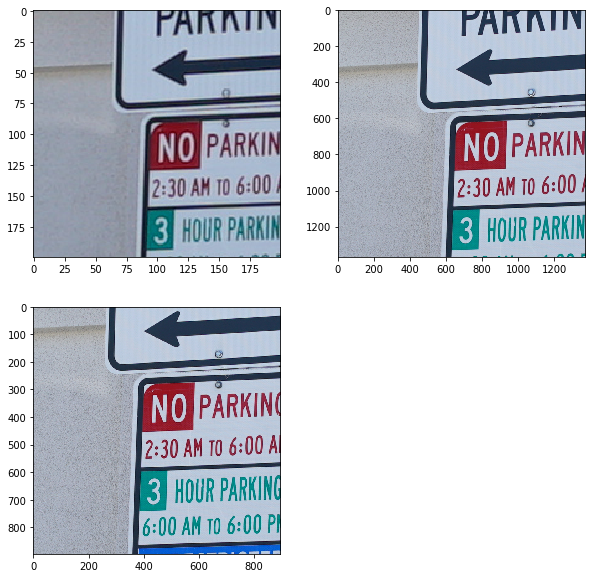

In [5]:
import utils
import cv2
import utils_align
def imgAlign(images, tform_txt, sour_idx, des_idx, clipped=False, height = 2500, width = 2500):
    t1, corner1 = utils.read_tform(tform_txt, "0000"+str(sour_idx))
    t2, corner2 = utils.read_tform(tform_txt, "0000"+str(des_idx))
    t2_inv = cv2.invertAffineTransform(t2)
    aligned_image_np = utils_align.apply_transform_single_image(images, t1, 'ECC', scale=1)
    aligned_image_np = utils_align.apply_transform_single_image(aligned_image_np, t2_inv, 'ECC', scale=1)
    ori_images_np = images
    if clipped == True:
        h, w = aligned_image_np.shape[:2]
        top = int((h - height) / 2)
        left =int((w - width) / 2)
        aligned_image_np = aligned_image_np[top:top+height,left:left+width,:]
        ori_images_np = images[top:top+height,left:left+width,:]
    return aligned_image_np, ori_images_np
    
    
images_list = []

import utils
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
fracx = fracy = 1./2
tform_txt = "/store/git/zoom-learn-zoom/quick_inference/00134/tform.txt"
white_lv, black_lv = utils.read_wb_lv("sony")
inference_path_lr = "/store/git/zoom-learn-zoom/quick_inference/00134/00006.ARW"
input_bayer = utils.get_bayer(inference_path_lr, black_lv, white_lv)
input_raw_reshape = utils.reshape_raw(input_bayer)

rgb_camera_path = inference_path_lr.replace(".ARW",".JPG")
rgb_camera_lr =  np.array(Image.open(rgb_camera_path))

height = 100
width = 100
input_raw_img_hw = utils.crop_center_wh(input_raw_reshape, height, width)
cropped_lr_hw = utils.crop_center_wh(rgb_camera_lr, height*2, width*2)


inference_path_hr = "/store/git/zoom-learn-zoom/quick_inference/00134/00002.JPG"
rgb_camera_hr =  np.array(Image.open(inference_path_hr))
crop_ratio = 240.0 / 157.0 
cropped_input_rgb_hr = utils.crop_fov(rgb_camera_hr, 1./crop_ratio)
cropped_input_rgb_hr = utils.image_float(cropped_input_rgb_hr)
input_camera_rgb_hr = Image.fromarray(np.uint8(utils.clipped(cropped_input_rgb_hr)*255))
input_camera_rgb_naive = input_camera_rgb_hr.resize((int(input_camera_rgb_hr.width * crop_ratio),
        int(input_camera_rgb_hr.height * crop_ratio)), Image.ANTIALIAS)
#input_camera_rgb_naive.save("align_arw_test/input_rgb_camera_HR.png")
hr = np.array(input_camera_rgb_naive)


print(input_raw_reshape.shape)
zoom_ratio = 240.0 / utils.readFocal_pil(inference_path_lr)

print("rgb_camera_hr.shape", rgb_camera_hr.shape)
print("hr.shape:", hr.shape)

aligned_hr_hw,_ = imgAlign(hr, tform_txt, 2, 6, True,int(height*2*zoom_ratio), int(width*2*zoom_ratio))
aligned_image = Image.fromarray(np.uint8(utils.clipped(aligned_hr_hw)))
aligned_image.save("align_arw_test/input_rgb_camera_alignedLHR.png")

zoom_ratio = utils.readFocal_pil(inference_path_hr) / utils.readFocal_pil(inference_path_lr)
cropped_hr_hw = utils.crop_center_wh(rgb_camera_hr, height*2*zoom_ratio, width*2*zoom_ratio)
#print(cropped_input_rgb_hw.shape)


plt.figure(figsize = (10,10))
plt.subplot(221)
plt.imshow(cropped_lr_hw)
plt.subplot(223)
plt.imshow(cropped_hr_hw)
plt.subplot(222)
plt.imshow(aligned_hr_hw)


plt.show()

In [ ]:
hr.shape[:2]

### LR->Aligned to HR

In [ ]:
import numpy as np
import utils
import cv2
from PIL import Image
import utils_align

print("Start alignment")
tform_txt = "/store/git/zoom-learn-zoom/quick_inference/00134/tform.txt"


t, corner = utils.read_tform(tform_txt, "00007")
t_inv = cv2.invertAffineTransform(t)

aligned_image_np = utils_align.apply_transform_single_image(lr, t, 'ECC', scale=1)
#images_t, t, t_inv = utils_align.apply_transform(images, t, t_inv, 'ECC', scale=1)

#print(images[0].shape)
aligned_image = Image.fromarray(np.uint8(utils.clipped(aligned_image_np)))
aligned_image.save("align_test/input_rgb_camera_alignedLR.png")
#cv2.imwrite(('align_test/input_rgb_camera_alignedLR.png'), np.uint8(255.*images[0]))

### HR Aligned to LR

In [ ]:
import numpy as np
import utils
import cv2
from PIL import Image
import utils_align

print("Start alignment")
tform_txt = "/store/git/zoom-learn-zoom/quick_inference/00134/tform.txt"
rsz = 0
t = np.zeros([2,3])
t_inv = np.zeros([2,3])

t, corner = utils.read_tform(tform_txt, "00007")
t_inv = cv2.invertAffineTransform(t)
print(t)

aligned_image_np = utils_align.apply_transform_single_image(hr, t_inv, 'ECC', scale=1)
aligned_image = Image.fromarray(np.uint8(utils.clipped(aligned_image_np)))
aligned_image.save("align_test/input_rgb_camera_alignedHR.png")

### LR Aligned to LHR

00006.png -> 00007.png

In [ ]:
import numpy as np
import utils
import cv2
from PIL import Image
import utils_align

print("Start alignment")
tform_txt = "/store/git/zoom-learn-zoom/quick_inference/00134/tform.txt"
rsz = 0

t, _ = utils.read_tform(tform_txt, "00006")
t_inv = cv2.invertAffineTransform(t)

t2, _ = utils.read_tform(tform_txt, "00007")
t2_inv = cv2.invertAffineTransform(t2)

print(t)
print(t2)

aligned_image_np = utils_align.apply_transform_single_image(lhr, t, 'ECC', scale=1)
aligned_image_np = utils_align.apply_transform_single_image(aligned_image_np, t2_inv, 'ECC', scale=1)

aligned_image = Image.fromarray(np.uint8(utils.clipped(aligned_image_np)))
aligned_image.save("align_test/input_rgb_camera_alignedLHR.png")

### HR Images Aligned to LR

In [ ]:
import numpy as np
import utils
import cv2
from PIL import Image
import utils_align

print("Start alignment")
tform_txt = "/store/git/zoom-learn-zoom/quick_inference/00134/tform.txt"
rsz = 0
t = np.zeros([1,2,3])
t_inv = np.zeros([1,2,3])

t[0], corner = utils.read_tform(tform_txt, "00007")
t_inv[0] = cv2.invertAffineTransform(t[0])
print(t)
images = []
images.append(lr)
#aligned_image_np = utils_align.apply_transform_single_image(lr, t, 'ECC', scale=1)
images_t, t, t_inv = utils_align.apply_transform(images, t, t_inv, 'ECC', scale=1)

print(images[0].shape)
aligned_image = Image.fromarray(np.uint8(utils.clipped(images_t[0])))
aligned_image.save("align_test/input_rgb_camera_alignedLR.png")
#cv2.imwrite(('align_test/input_rgb_camera_alignedLR.png'), np.uint8(255.*images[0]))

## main_align_camera.py

In [ ]:
import cv2,os,argparse
import numpy as np
from timeit import default_timer as timer

import utils as utils
import utils_align as utils_align

align = True
MOTION_MODEL = 'ECC'
ref_ind = 0

rsz = 3
folder = "/store/git/zoom-learn-zoom/quick_inference/00134/"

images = []
image_ds = []

allfiles=[f for f in os.listdir(folder + 'cropped/')]

imlist=[filename for filename in allfiles if filename[-4:] in [".jpg", ".JPG",".png",".PNG"]]
num_img = len(imlist)

print("Total read in %d images"%num_img)
for impath in sorted(imlist):
    img_rgb = cv2.imread(folder + 'cropped/' + impath, -1)
    #print(folder + 'cropped/' + impath)
    img_rgb = utils.image_float(img_rgb)  # normalize to [0, 1]
    images.append(img_rgb)
    img_rgb_ds = cv2.resize(img_rgb, None, fx=1./(2 ** rsz), fy=1./(2 ** rsz),
        interpolation=cv2.INTER_CUBIC)
    image_ds.append(img_rgb_ds)
    #print(img_rgb_ds.shape)
    #print(img_rgb.shape)

image_ds = image_ds[ref_ind:]


print("Start alignment")
tform_txt = "/store/git/zoom-learn-zoom/quick_inference/00134/tform.txt"
#tform_txt = None
alg_start = timer()
images_gray = utils.bgr_gray(image_ds)
valid_id = [0,1,2,3,4,5,6]
if tform_txt == None:
    if MOTION_MODEL == 'ECC':
        t, t_inv, valid_id = utils_align.align_ecc(image_ds, images_gray, 0, thre=0.3)
    elif MOTION_MODEL == 'RIGID':
        t, t_inv, valid_id = utils_align.align_rigid(image_ds, images_gray, 0, thre=0.2)
    alg_end = timer()
else:
    rsz = 0
    t = np.zeros([7,2,3])
    t_inv = np.zeros([7,2,3])
    for i in range(7):
        t[i], center = utils.read_tform(tform_txt, "0000"+str(i+1))
        t_inv[i] = cv2.invertAffineTransform(t[i])
    alg_end = timer()
print("Full alignment: " + str(alg_end - alg_start) + "s")


print(type(t))
print(t.shape)

print(images[6].shape)

images_t, t, t_inv = utils_align.apply_transform(images, t, t_inv, MOTION_MODEL, scale=2 ** rsz)
print(images_t[1].shape)

#print(images_t[6])
aligned_image = Image.fromarray(np.uint8(255.*images_t[6]))
aligned_image.save("align_test/input_rgb_camera_alignedLR_comp.png")

cv2.imwrite(('align_test/input_rgb_camera_alignedLR_comp2.png'), np.uint8(255.*images_t[6]))


In [ ]:

out_sum = os.path.join(folder, 'compare')

height, width = img_rgb.shape[0:2]
corner = np.array([[0,0,width,width],[0,height,0,height],[1,1,1,1]])
for i in range(num_img):
    corner_out = np.matmul(np.vstack([np.array(t_inv[i]),[0,0,1]]),corner)
    corner_out[0,:] = np.divide(corner_out[0,:],corner_out[2,:])
    corner_out[1,:] = np.divide(corner_out[1,:],corner_out[2,:])
    corner_out = corner_out[..., np.newaxis]
    if i == 0:
        corner_t = corner_out
    else:
        corner_t = np.append(corner_t,corner_out,2)

print("Valid IDs: ",valid_id)
images_t = list(images_t[i] for i in valid_id)
images = list(images[i] for i in valid_id)
imlist = list(imlist[i] for i in valid_id)
num_img = len(images_t)

################ CROP & COMPARE ################
min_w = np.max(corner_t[0,[0,1],:])
min_w = int(np.max(np.ceil(min_w),0))
min_h = np.max(corner_t[1,[0,2],:])
min_h = int(np.max(np.ceil(min_h),0))
max_w = np.min(corner_t[0,[2,3],:])
max_w = int(np.floor(max_w))
max_h = np.min(corner_t[1,[1,3],:])
max_h = int(np.floor(max_h))


if ref_ind == 0:
    sum_img_t, sum_img = utils_align.sum_aligned_image(images_t, images)

    i = 0
    for impath in sorted(imlist):  
        img_t = images_t[i]
        i += 1
        print("write to: ",(folder + 'aligned/' + impath))
#         img_t_crop = img_t[min_h:max_h,min_w:max_w,:]
#         wt, ht = img_t_crop.shape[:2]
#         ratio = 512 / min(wt, ht)
#         img_t_crop_ds = cv2.resize(img_t_crop, None, fx=ratio, fy=ratio,
#             interpolation=cv2.INTER_CUBIC)
        img_t_crop = img_t
        cv2.imwrite((folder + 'aligned/' + impath), np.uint8(255.*img_t_crop))

    cv2.imwrite(os.path.join(out_sum,'aligned.jpg'), np.uint8(255.*sum_img_t))
    cv2.imwrite(os.path.join(out_sum,'orig.jpg'), np.uint8(255.*sum_img))

In [12]:
import numpy as np
a = np.array([5,6,4])
print(np.power(a,2))

[25 36 16]


In [16]:
log_line = "[PSNR] [SSIM] [calc Time] [Loop Time] for lr and hr %.4f %.4f %.4f %.4f:" \
    %(10, 10, 10, 10)

print(log_line)

[PSNR] [SSIM] [calc Time] [Loop Time] for lr and hr 10.0000 10.0000 10.0000 10.0000:
